# Random Forest for Regression

In this Jupyter notebook we're going to use Random Forest on our boston dataset

| Model Name  | MAE  |
|---|---|
| Linear Regression  | 4517 |
| SVR(kernel='linear') | 4247  |
| SVR(kernel='rbf') | 3103  |
| Decision Trees  | 3500  |

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston
boston = load_boston()
boston_df = pd.DataFrame(data=boston['data'], columns=boston['feature_names'])
X = boston_df
y = boston['target']

## Split test data

In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### util functions

In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def get_model_scores(regressor, training_data, test_data):
    
    X_train, y_train = training_data
    X_test, y_test = test_data
    
    training_mse = mean_squared_error(y_train, regressor.predict(X_train))
    training_mae = mean_absolute_error(y_train, regressor.predict(X_train))

    test_mse = mean_squared_error(y_test, regressor.predict(X_test))
    test_mae = mean_absolute_error(y_test, regressor.predict(X_test))
    
    training_r2_score = r2_score(y_train, regressor.predict(X_train))
    test_r2_score = r2_score(y_test, regressor.predict(X_test))

    return  {
        "mse": [training_mse, test_mse],
        "mae": [training_mae, test_mae],
        "r2": [training_r2_score, test_r2_score],
        "oob": [regressor.oob_score_]
    }

def print_model_scores(regressor, training_data, test_data):
    
    X_train, y_train = training_data
    X_test, y_test = test_data
    
    results = get_model_scores(regressor, training_data, test_data)

    print("Training set MSE: {:.3f}".format(results["mse"][0]))
    print("Test set MSE: {:.3f}".format(results["mse"][1]))
    print()
    print("Training set MAE: {:.2f}".format(results["mae"][0]*1000))
    print("Test set MAE: {:.2f}".format(results["mae"][1]*1000))
    print()
    print("Training set r2: {:.3f}".format(results["r2"][0]))
    print("Test set r2: {:.2f}".format(results["r2"][1]))
    print()
    print("Out-of-Bag r2: {:.2f}".format(results["oob"][0]))

## Default settings for RF Regressor

Note: n_estimators == # trees

In [4]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 100, oob_score=True, random_state = 42)
regressor.fit(X_train, y_train)
print_model_scores(regressor, (X_train, y_train), (X_test, y_test))

Training set MSE: 1.978
Test set MSE: 7.902

Training set MAE: 903.48
Test set MAE: 2039.54

Training set r2: 0.977
Test set r2: 0.89

Out-of-Bag r2: 0.84


## Set the regressor to do bagging

In [5]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 100, bootstrap=True, max_samples=0.8, 
                                  oob_score=True, random_state = 42)
regressor.fit(X_train, y_train)
print_model_scores(regressor, (X_train, y_train), (X_test, y_test))

Training set MSE: 2.746
Test set MSE: 7.979

Training set MAE: 1067.21
Test set MAE: 2043.43

Training set r2: 0.968
Test set r2: 0.89

Out-of-Bag r2: 0.84


## .. add in feature bagging 'aka' 

In [6]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 100, bootstrap=True, 
                                  max_samples=0.8, 
                                  max_features=0.3,
                                  oob_score=True, random_state = 42)
regressor.fit(X_train, y_train)
print_model_scores(regressor, (X_train, y_train), (X_test, y_test))

Training set MSE: 2.496
Test set MSE: 10.015

Training set MAE: 1075.25
Test set MAE: 2008.10

Training set r2: 0.971
Test set r2: 0.86

Out-of-Bag r2: 0.85


### ... configure stopping criteria on the RT

In [7]:
regressor

RandomForestRegressor(max_features=0.3, max_samples=0.8, oob_score=True,
                      random_state=42)

In [8]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 100, bootstrap=True, 
                                  max_samples=0.8, 
                                  max_features=0.3,
                                  min_impurity_decrease=0.2, 
                                  oob_score=True, random_state = 42)
regressor.fit(X_train, y_train)
print_model_scores(regressor, (X_train, y_train), (X_test, y_test))

Training set MSE: 5.601
Test set MSE: 11.149

Training set MAE: 1797.56
Test set MAE: 2225.44

Training set r2: 0.936
Test set r2: 0.85

Out-of-Bag r2: 0.83


## Plot MAE against tree

Text(0, 0.5, 'Error')

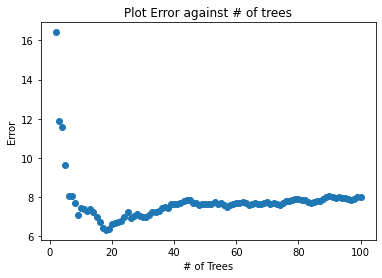

In [9]:
import matplotlib.pyplot as plt
min_trees = 1
max_trees = 100
trees_mse_scores = np.zeros((max_trees-min_trees, 3))
for n_trees in range(min_trees, max_trees):
    regressor = RandomForestRegressor(n_estimators = n_trees+1, bootstrap=True, max_samples=0.8, 
                                      oob_score=True, random_state = 42).fit(X_train, y_train)
    model_scores = get_model_scores(regressor, (X_train, y_train), (X_test, y_test))
    trees_mse_scores[n_trees-min_trees][0] = n_trees +1
    trees_mse_scores[n_trees-min_trees][1] = model_scores["mse"][1]
    trees_mse_scores[n_trees-min_trees][2] = model_scores["mae"][1]    
    
x = trees_mse_scores[:,0]
y1 = trees_mse_scores[:,1]
y2 = trees_mse_scores[:,2]    

plt.scatter(x, y1)
#plt.scatter(x, y2)
plt.title("Plot Error against # of trees")
plt.xlabel("# of Trees")
plt.ylabel("Error")

### K-fold CV Score

In [10]:
from sklearn.model_selection import cross_val_score
regressor = RandomForestRegressor(n_estimators = 100, bootstrap=True, 
                                  max_features=0.6,
                                  max_samples=0.8, oob_score=True, random_state = 42)

mae_dt = cross_val_score(regressor, X, y, cv=5, scoring='neg_mean_absolute_error')
print("MAE : {:.2f}".format(np.abs(np.mean(mae_dt))*1000))

MAE : 2923.15


### Plot Predicted against Actuals

In [11]:
regressor.fit(X_train, y_train)
predicted = regressor.predict(X_test)

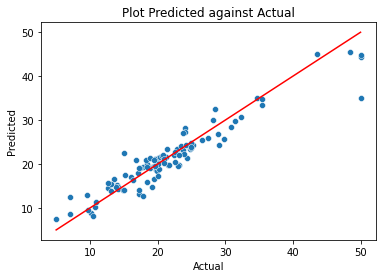

In [12]:
import seaborn as sns
sns.scatterplot(y_test, predicted)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='r')
plt.title("Plot Predicted against Actual")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

## Plot residuals

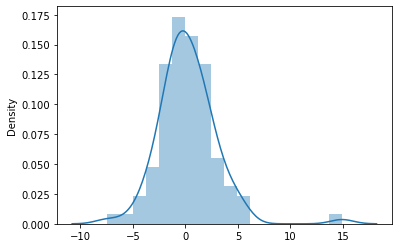

In [13]:
sns.distplot(y_test - predicted)
plt.show()